In [1]:
import json
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import image as mpimg

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report


Bad key "text.kerning_factor" on line 4 in
C:\Users\adamf\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Load and Split VQA Data

In [2]:
def load_annotations(filepath):
    with open(filepath) as json_file:
        data = json.load(json_file)
        data = data['annotations']
    return data

def load_questions(filepath):
    with open(filepath) as json_file:
        data = json.load(json_file)
        data = data['questions']
    return data

In [3]:
def plot_image(image_id,val=False):
    if val:
        path = 'val2014/COCO_val2014_000000'
        
    else:
        path = 'train2014/COCO_train2014_000000'
        
    img = mpimg.imread(path + str(image_id) + '.jpg')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    

In [4]:
val_annotation_path = 'v2_Annotations_Val_mscoco/v2_mscoco_val2014_annotations.json'
trn_annotation_path = 'v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json'

val_questions_path = 'v2_Questions_Val_mscoco/v2_OpenEnded_mscoco_val2014_questions.json'
trn_questions_path = 'v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json'

In [5]:
trn_labels = load_annotations(trn_annotation_path)
val_labels = load_annotations(val_annotation_path)

trn_quests = load_questions(trn_questions_path)
val_quests = load_questions(val_questions_path)

In [6]:
val = [(label['question_type'], question['image_id'], question['question']) for label, question in zip(val_labels,val_quests)]
train = [(label['question_type'], question['image_id'], question['question']) for label, question in zip(trn_labels,trn_quests)]

In [7]:
X_train = [item['question'] for item in trn_quests]
y_train = [item['question_type'] for item in trn_labels]
X_val = [item['question'] for item in val_quests]
y_val = [item['question_type'] for item in val_labels]

# Preprocess VQA Data (simplify question types)

In [8]:
fewer_y_train = []
fewer_y_val = []

existence_q = ['are there', 'is that a', 'what', 'what is the name',  
                 'what is this', 'are these', 'is there', 'is there a', 
                 'are these', 'are', 'is it', 'is', 'this an', 
                 'is this a','what are','are there any','what is']

color_q = ['what color', 'what color is the','what color are the']
where_q = ['where is the', 'where are the']
how_many = ['how many people are in', 'how many']

In [9]:
for item in y_train:
    if item in existence_q:
        item = 'is there'
    elif item in color_q:
        item = 'what color'
    elif item in where_q:
        item = 'where'
    elif item in how_many:
        item = 'how many'
    else:
        item = 'other'
    fewer_y_train.append(item)

for item in y_val:
    if item in existence_q:
        item = 'is there'
    elif item in color_q:
        item = 'what color'
    elif item in where_q:
        item = 'where'
    elif item in how_many:
        item = 'how many'
    else:
        item = 'other'
    fewer_y_val.append(item)


In [10]:
len(set(y_train)), len(set(fewer_y_train))

(65, 5)

# SGD Classifier

In [11]:
sgd_pipeline = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,4))),
                         ('clf', SGDClassifier())])
sgd_parameters = {'tfidf__lowercase': [True, False],
                  'tfidf__analyzer': ['word', 'char', 'char_wb'],
                  'tfidf__stop_words': [None, 'english'],
                  'tfidf__ngram_range': [(1,1),(1,3),(1,5)],
                  'tfidf__norm': ['l1', 'l2'],
                  'tfidf__use_idf': [True, False],
                  'tfidf__smooth_idf': [True, False],
                  'tfidf__sublinear_tf': [True, False],
                  
                  'clf__loss': [ 'hinge', 'log', 'modified_huber', 'squared_hinge'],
                  'clf__alpha': [1e-3, 1e-4, 1e-5],
                  'clf__l1_ratio': np.linspace(0,1,4),
                  'clf__random_state': [1]
                 }
sgd_model = GridSearchCV(sgd_pipeline, sgd_parameters,n_jobs=-1)

## Find Optimal Parameters

In [12]:
sgd_model.fit(X_train[:5000], fewer_y_train[:5000])

In [13]:
sgd_model.best_params_

{'clf__alpha': 0.0001,
 'clf__l1_ratio': 0.0,
 'clf__loss': 'hinge',
 'clf__random_state': 1,
 'tfidf__analyzer': 'word',
 'tfidf__lowercase': False,
 'tfidf__ngram_range': (1, 3),
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': False}



## Train and Score Model with Optimal Parameters

In [14]:
opt_pipeline = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,3),
                                                   lowercase=False,
                                                   norm='l2',
                                                   smooth_idf=True, 
                                                   sublinear_tf=False, 
                                                   use_idf=False)),
                         ('clf', SGDClassifier(alpha=0.0001, loss='hinge', penalty='l2', random_state=1))])
opt_pipeline.fit(X_train, fewer_y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 3),
                                 use_idf=False)),
                ('clf', SGDClassifier(random_state=1))])

In [15]:
opt_pipeline.score(X_val, fewer_y_val)

0.9773318902376442

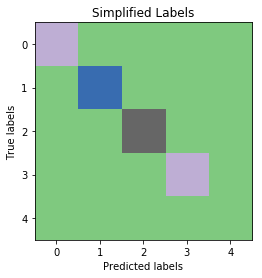

              precision    recall  f1-score   support

    how many       1.00      1.00      1.00     21367
    is there       0.94      0.99      0.96     58296
       other       0.99      0.96      0.98    111055
  what color       0.99      1.00      1.00     18607
       where       1.00      1.00      1.00      5029

    accuracy                           0.98    214354
   macro avg       0.98      0.99      0.99    214354
weighted avg       0.98      0.98      0.98    214354



In [16]:
preds = opt_pipeline.predict(X_val)
plt.imshow(confusion_matrix(fewer_y_val,preds),cmap='Accent')
plt.title('Simplified Labels')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.savefig('simplified_cf_opt.png')
plt.show()
print(classification_report(fewer_y_val,preds))

### Train Model on Full Dataset

In [17]:
model = opt_pipeline.fit(X_train+X_val, fewer_y_train+fewer_y_val)

## Train and Score with Default Parameters

In [18]:
default_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', SGDClassifier(random_state=1))])
default_pipeline.fit(X_train, fewer_y_train)
default_pipeline.score(X_val, fewer_y_val)

0.8867294288886608

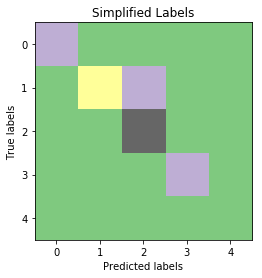

              precision    recall  f1-score   support

    how many       0.93      0.99      0.96     21367
    is there       0.89      0.76      0.82     58296
       other       0.88      0.91      0.89    111055
  what color       0.91      0.97      0.94     18607
       where       0.84      0.99      0.91      5029

    accuracy                           0.89    214354
   macro avg       0.89      0.92      0.90    214354
weighted avg       0.89      0.89      0.88    214354



In [19]:
preds = default_pipeline.predict(X_val)
plt.imshow(confusion_matrix(fewer_y_val,preds),cmap='Accent')
plt.title('Simplified Labels')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.savefig('simplified_cf_bad.png')
plt.show()
print(classification_report(fewer_y_val,preds))

## Train and Score with Specialized Labels (65)

In [20]:
all_labels_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                         ('clf', SGDClassifier(random_state=1))])
all_labels_pipeline.fit(X_train, y_train)
all_labels_pipeline.score(X_val, y_val)

0.8705505845470577

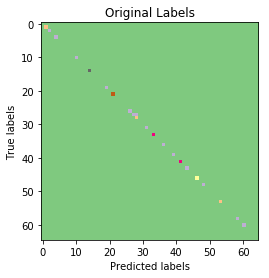

C:\Users\adamf\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                          precision    recall  f1-score   support

                     are       0.83      0.60      0.70      2359
                 are the       0.88      0.97      0.92      5264
               are there       0.97      0.97      0.97      2771
           are there any       0.84      0.99      0.91      1330
               are these       0.87      0.99      0.92      2839
                are they       0.98      0.99      0.99      1335
                 can you       0.87      0.96      0.91       872
                   could       0.76      1.00      0.86       618
                      do       0.88      0.97      0.92      1503
                  do you       0.86      0.93      0.89       724
                does the       0.81      0.96      0.87      3183
               does this       0.88      0.94      0.91      2227
                     has       0.86      0.98      0.91       946
                     how       0.93      0.97      0.95      2422
         

In [21]:
preds = all_labels_pipeline.predict(X_val)
plt.imshow(confusion_matrix(y_val,preds),cmap='Accent')
plt.title('Original Labels')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.savefig('original_cf.png')
plt.show()

print(classification_report(y_val,preds))